In [1]:
import ciw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from tqdm.notebook import tqdm
import pickle

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
import sd_component as sd

### System Dynamics Component

In [3]:
A = sd.SD(
    initial_population=100000,
    unwell_proportion=0.1,
    unwell_splits=[0.1, 0.3, 0.6],
    gatekeeping_function=sd.proportional_gatekeeping(threshold=0.4),
    presenting_rate=0.002 / 3,
    deterioration_rate=0.005,
    incidence_rate=0,
)
ts = np.linspace(0, 1000, 100000 + 1)
A.solve(t=ts)

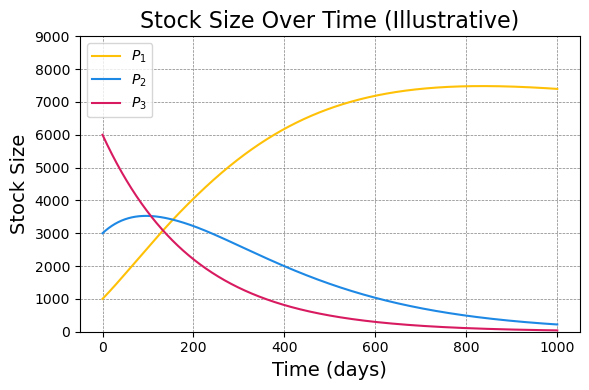

<Figure size 640x480 with 0 Axes>

In [4]:
sd.plot_stocks_over_time(
    A.P,
    t=ts,
    ylim=(0, 9000),
    title="Stock Size Over Time (Illustrative)",
    filename="plots/stock_size.pdf")

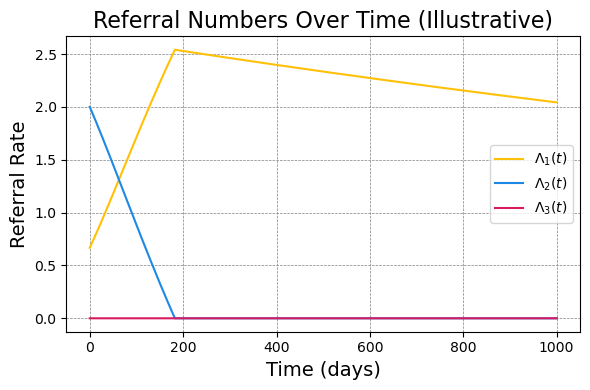

<Figure size 640x480 with 0 Axes>

In [6]:
sd.plot_referral_numbers_over_time(
    A.lambdas,
    t=ts,
    title="Referral Numbers Over Time (Illustrative)",
    filename="plots/referral_numbers.pdf")

### Loading the Subgroup PDFAs

In [7]:
pdfa_one = np.load("../pdfas/example_high_pdfa.npy")
pdfa_one_alphabet = pickle.load(open("../pdfas/example_high_pdfa_alphabet.pkl", "rb"))

In [8]:
pdfa_two = np.load("../pdfas/example_medium_pdfa.npy")
pdfa_two_alphabet = pickle.load(open("../pdfas/example_medium_pdfa_alphabet.pkl", "rb"))

In [9]:
pdfa_three = np.load("../pdfas/example_low_pdfa.npy")
pdfa_three_alphabet = pickle.load(open("../pdfas/example_low_pdfa_alphabet.pkl", "rb"))

In [10]:
activity_dict = dict()
activity_dict["A"] = 2
activity_dict["B"] = 3
activity_dict["C"] = 4
activity_dict["D"] = 5
activity_dict["F"] = 6
activity_dict["G"] = 7
activity_dict["H"] = 8
activity_dict["I"] = 9
activity_dict["J"] = 10
inv_dict = {v: k for k, v in activity_dict.items()}
inv_dict[1] = ""

In [11]:
nodes = ["*", "A", "B", "C", "D", "F", "G", "H", "I", "J"]

### Discrete-Event Simulation Component

In [ ]:
class HighCustomRouting(ciw.routing.NodeRouting):
    """
    A custom routing class for patients based on a probabilistic finite
    deterministic automaton (PDFA) with a high-severity level.

    This class inherits from the `NodeRouting` class in the `ciw` library.

    Attributes
    ----------
    simulation : ciw.Simulation
        The simulation object that contains the network and other parameters.
    pdfa : numpy.ndarray
        The PDFA transition matrix.
    pdfa_alphabet : list
        The alphabet of the PDFA, representing the activities.
    activity_dict : dict
        A dictionary mapping activity names to their corresponding indices in 
        the PDFA.

    Methods
    -------
    next_node(ind)
        Determines the next node for a given individual based on the PDFA.
    """
    def next_node(self, ind):
        p_matrix = pdfa_one
        alphabet = pdfa_one_alphabet

        if hasattr(ind, "route_position") == False:
            ind.route_position = 1
        leaving_row = ind.route_position
        p_values = []
        next_state = []
        next_activity = []
        for letter in range(len(alphabet)):
            if p_matrix[letter, leaving_row, :].sum() > 0:
                p_values.append(p_matrix[letter, leaving_row, :].sum())
                next_state.append(np.where(p_matrix[letter, leaving_row, :] > 0)[0][0])
                next_activity.append(letter)
        final_prob = 1 - sum(p_values)
        if final_prob > 0:
            p_values.append(final_prob)
            next_state.append("tau")
            next_activity.append(-1)
        next = np.random.choice(a=next_activity, p=p_values)
        next_position = next_state[next_activity.index(next)]
        if next == -1:
            ind.route_position = -1
            return self.simulation.nodes[-1]
        else:
            next_node = activity_dict[alphabet[next]]
            ind.route_position = next_position
            return self.simulation.nodes[next_node]

In [ ]:
class MediumCustomRouting(ciw.routing.NodeRouting):
    """
    A custom routing class for patients based on a probabilistic finite
    deterministic automaton (PDFA) with a medium-severity level.

    This class inherits from the `NodeRouting` class in the `ciw` library.

    Attributes
    ----------
    simulation : ciw.Simulation
        The simulation object that contains the network and other parameters.
    pdfa : numpy.ndarray
        The PDFA transition matrix.
    pdfa_alphabet : list
        The alphabet of the PDFA, representing the activities.
    activity_dict : dict
        A dictionary mapping activity names to their corresponding indices in 
        the PDFA.

    Methods
    -------
    next_node(ind)
        Determines the next node for a given individual based on the PDFA.
    """
    def next_node(self, ind):
        p_matrix = pdfa_two
        alphabet = pdfa_two_alphabet

        if hasattr(ind, "route_position") == False:
            ind.route_position = 1
        leaving_row = ind.route_position
        p_values = []
        next_state = []
        next_activity = []
        for letter in range(len(alphabet)):
            if p_matrix[letter, leaving_row, :].sum() > 0:
                p_values.append(p_matrix[letter, leaving_row, :].sum())
                next_state.append(np.where(p_matrix[letter, leaving_row, :] > 0)[0][0])
                next_activity.append(letter)
        final_prob = 1 - sum(p_values)
        if final_prob > 0:
            p_values.append(final_prob)
            next_state.append("tau")
            next_activity.append(-1)
        next = np.random.choice(a=next_activity, p=p_values)
        next_position = next_state[next_activity.index(next)]
        if next == -1:
            ind.route_position = -1
            return self.simulation.nodes[-1]
        else:
            next_node = activity_dict[alphabet[next]]
            ind.route_position = next_position
            return self.simulation.nodes[next_node]

In [ ]:
class LowCustomRouting(ciw.routing.NodeRouting):
    """
    A custom routing class for patients based on a probabilistic finite
    deterministic automaton (PDFA) with a low-severity level.

    This class inherits from the `NodeRouting` class in the `ciw` library.

    Attributes
    ----------
    simulation : ciw.Simulation
        The simulation object that contains the network and other parameters.
    pdfa : numpy.ndarray
        The PDFA transition matrix.
    pdfa_alphabet : list
        The alphabet of the PDFA, representing the activities.
    activity_dict : dict
        A dictionary mapping activity names to their corresponding indices in 
        the PDFA.

    Methods
    -------
    next_node(ind)
        Determines the next node for a given individual based on the PDFA.
    """
    def next_node(self, ind):
        p_matrix = pdfa_three
        alphabet = pdfa_three_alphabet

        if hasattr(ind, "route_position") == False:
            ind.route_position = 1
        leaving_row = ind.route_position
        p_values = []
        next_state = []
        next_activity = []
        for letter in range(len(alphabet)):
            if p_matrix[letter, leaving_row, :].sum() > 0:
                p_values.append(p_matrix[letter, leaving_row, :].sum())
                next_state.append(np.where(p_matrix[letter, leaving_row, :] > 0)[0][0])
                next_activity.append(letter)
        final_prob = 1 - sum(p_values)
        if final_prob > 0:
            p_values.append(final_prob)
            next_state.append("tau")
            next_activity.append(-1)
        next = np.random.choice(a=next_activity, p=p_values)
        next_position = next_state[next_activity.index(next)]
        if next == -1:
            return self.simulation.nodes[-1]
        else:
            next_node = activity_dict[alphabet[next]]
            ind.route_position = next_position
            return self.simulation.nodes[next_node]

In [15]:
N = ciw.create_network(
    arrival_distributions={
        "Low": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[2][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
        "Medium": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[1][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
        "High": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[0][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
    },
    service_distributions={
        "Low": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
        "Medium": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
        "High": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
    },
    number_of_servers=[float("inf"), 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    routing={
        "Low": ciw.routing.NetworkRouting(
            routers=[
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
                LowCustomRouting(),
            ]
        ),
        "Medium": ciw.routing.NetworkRouting(
            routers=[
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
                MediumCustomRouting(),
            ]
        ),
        "High": ciw.routing.NetworkRouting(
            routers=[
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
                HighCustomRouting(),
            ]
        ),
    },
)

In [16]:
Q = ciw.Simulation(N)
Q.simulate_until_max_time(1000)
r = pd.DataFrame(Q.get_all_records())
r

,id_number,customer_class,original_customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,server_id,record_type
0,2401,High,High,1,999.887792,0.000000,999.887792,0.000000,999.887792,0.0,999.887792,2,0,0,False,service
1,2399,High,High,1,999.737282,0.000000,999.737282,0.000000,999.737282,0.0,999.737282,2,0,0,False,service
2,2399,High,High,2,999.737282,0.000000,999.737282,0.100000,999.837282,0.0,999.837282,5,0,1,1,service
3,2400,High,High,1,999.816528,0.000000,999.816528,0.000000,999.816528,0.0,999.816528,2,0,0,False,service
4,2400,High,High,2,999.816528,0.020754,999.837282,0.100000,999.937282,0.0,999.937282,5,1,1,1,service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12860,2395,High,High,5,997.817503,0.276334,998.093837,0.285714,998.379551,0.0,998.379551,-1,1,1,1,service
12861,2381,High,High,1,987.764528,0.000000,987.764528,0.000000,987.764528,0.0,987.764528,2,0,0,False,service
12862,2381,High,High,2,987.764528,0.000000,987.764528,0.100000,987.864528,0.0,987.864528,5,0,0,1,service
12863,2381,High,High,5,987.864528,0.000000,987.864528,0.285714,988.150242,0.0,988.150242,10,0,0,1,service
